# Validation Mode

<div class="alert alert-block alert-info">
<b>This mode is used if the nature/label of the event is known in advance. </b>
</div>

## Download data

Input data should be in **mseed** format and correspond to raw **60 second 3-component seismograms**. 

Demo data is available in the "mseed" folder. 

To apply the algorithm, we need a folder architecture:
* mseed_demo
   * 2022004T134407
        * FR_CHLF_2022004T134407.mseed
        * FR_GARF_2022004T134407.mseed
        * FR_GNEF_2022004T134407.mseed
        * FR_VERF_2022004T134407.mseed
        
The name of the mseed file should be formatted as "{network} _ {station} _ {time_event}.mseed".

To apply this mode, a **csv file** import pandas as pd is also required with the associated label for each event. 

In [94]:
import pandas as pd
import numpy as np 
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict


from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

import sys
sys.path.append('../../discrimination_eq_q/')
sys.path.append('../../discrimination_eq_q/model/')
sys.path.append('/home/ipt/projetos/Classificador_Sismologico/files/')

from data_process import spectro_extract
from prediction import discrim


In [98]:
# Events file
# commercial_events = np.genfromtxt(f'../files/predcsv/pred_commercial.csv', delimiter=',', skip_header = 1, dtype=str)
notcommercial_events = np.genfromtxt(f'../files/predcsv/pred_not_commercial.csv', delimiter=',', skip_header = 1, dtype=str)

In [99]:
#print(f' #Business Hour Events: {commercial_events.shape}')
print(f' #Non-Busines Hour Events: {notcommercial_events.shape}')

 #Non-Busines Hour Events: (1122, 2)


# Non-Commercial Hour Events

## Calculate Spectre

In [4]:
data = spectro_extract(data_dir="/home/ipt/projetos/Classificador_Sismologico/files/mseed", spectro_dir="/home/ipt/projetos/Classificador_Sismologico/files/spectro", events_list=notcommercial_events)

Number of events: 1122
*****************
EVENT 1 / 1122
Number of streams: 2
*****************
EVENT 2 / 1122
Number of streams: 3
*****************
EVENT 3 / 1122
Number of streams: 3
*****************
EVENT 4 / 1122
Number of streams: 3
*****************
EVENT 5 / 1122
Number of streams: 3
*****************
EVENT 6 / 1122
Number of streams: 8
*****************
EVENT 7 / 1122
Number of streams: 1
*****************
EVENT 8 / 1122
Number of streams: 4
*****************
EVENT 9 / 1122
Number of streams: 3
*****************
EVENT 10 / 1122
Number of streams: 4
*****************
EVENT 11 / 1122
Number of streams: 2
*****************
EVENT 12 / 1122
Number of streams: 1
*****************
EVENT 13 / 1122
Number of streams: 1
*****************
EVENT 14 / 1122
Number of streams: 1
*****************
EVENT 15 / 1122
Number of streams: 1
*****************
EVENT 16 / 1122
Number of streams: 1
*****************
EVENT 17 / 1122
Number of streams: 3
*****************
EVENT 18 / 1122
Number of streams

../../discrimination_eq_q/data_process.py:159: RuntimeWarning: invalid value encountered in true_divide
  fft_list /= fft_list.max()


*****************
EVENT 801 / 1122
Number of streams: 2
*****************
EVENT 802 / 1122
Number of streams: 1
*****************
EVENT 803 / 1122
Number of streams: 2
*****************
EVENT 804 / 1122
Number of streams: 4
*****************
EVENT 805 / 1122
Number of streams: 3
*****************
EVENT 806 / 1122
Number of streams: 1
*****************
EVENT 807 / 1122
Number of streams: 1
*****************
EVENT 808 / 1122
Number of streams: 1
*****************
EVENT 809 / 1122
Number of streams: 1
*****************
EVENT 810 / 1122
Number of streams: 3
*****************
EVENT 811 / 1122
Number of streams: 1
*****************
EVENT 812 / 1122
Number of streams: 4
*****************
EVENT 813 / 1122
Number of streams: 2
*****************
EVENT 814 / 1122
Number of streams: 1
*****************
EVENT 815 / 1122
Number of streams: 1
*****************
EVENT 816 / 1122
Number of streams: 1
*****************
EVENT 817 / 1122
Number of streams: 1
*****************
EVENT 818 / 1122
Number of str

## Run validation

In [ ]:
discrim(model_dir="../../discrimination_eq_q/model/model_2021354T1554.h5", spectro_dir='/home/ipt/projetos/Classificador_Sismologico/files/spectro/', output_dir="/home/ipt/projetos/Classificador_Sismologico/files/output/non_commercial/", event_label=notcommercial_events, valid = True)

Number of events: 1122
*****************
EVENT 1 / 1122
Number of station: 2
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 2 / 1122
Number of station: 3
1/1 [==============================] - 0s 20ms/step
*****************
EVENT 3 / 1122
Number of station: 3
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 4 / 1122
Number of station: 3
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 5 / 1122
Number of station: 3
1/1 [==============================] - 0s 16ms/step
*****************
EVENT 6 / 1122
Number of station: 8
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 7 / 1122
Number of station: 1
1/1 [==============================] - 0s 18ms/step
*****************
EVENT 8 / 1122
Number of station: 4
1/1 [==============================] - 0s 14ms/step
*****************
EVENT 9 / 1122
Number of station: 3
1/1 [==============================] - 0s 16ms/step
*****************
EVENT

## Predições em Rede

In [2]:
pred_net = pd.read_csv("../files/output/non_commercial/validation_network_level.csv")
pred_net.sort_values(by='prob_ant',ascending=False).head(10)

,event,label_cat,prob_nat,prob_ant,pred,nature
1087,20220526T232337,0,0.003,0.997,1,Anthropogenic
438,20200617T014050,0,0.009,0.991,1,Anthropogenic
961,20170719T224601,0,0.010,0.990,1,Anthropogenic
563,20191112T104033,0,0.010,0.990,1,Anthropogenic
762,20231120T065713,0,0.013,0.987,1,Anthropogenic
275,20160119T011141,0,0.015,0.985,1,Anthropogenic
1056,20180927T095909,0,0.018,0.982,1,Anthropogenic
917,20160604T033149,0,0.019,0.981,1,Anthropogenic
800,20151125T043030,0,0.022,0.978,1,Anthropogenic
718,20151124T234414,0,0.025,0.975,1,Anthropogenic


In [3]:
pred_net.shape

(1119, 6)

### Rótulos dos sismos

In [11]:
print('SIMSMOS ROTULADOS COMO:')
sismo_natural = pred_net[pred_net['label_cat'] == 0]
print(f'    sismos naturais - > {len(sismo_natural)}')
sismo_antrop = pred_net[pred_net['label_cat'] == 1]
print(f'    sismos antrópicos - > {len(sismo_antrop)}')

SIMSMOS ROTULADOS COMO:
    sismos naturais - > 1119
    sismos antrópicos - > 0


In [12]:
print('SIMSMOS CLASSIFICADOS COMO:')
sismo_falso_natural = sismo_antrop[sismo_antrop['pred'] == 0 ]
print(f'    sismos naturais falsos - > {len(sismo_falso_natural)}')
sismo_falso_antro = sismo_natural[sismo_natural['pred'] == 1 ]
print(f'    sismos antropogênicos falsos - > {len(sismo_falso_antro)}')

SIMSMOS CLASSIFICADOS COMO:
    sismos naturais falsos - > 0
    sismos antropogênicos falsos - > 143


/tmp/ipykernel_1401567/2448455418.py:11: RuntimeWarning: divide by zero encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100
/tmp/ipykernel_1401567/2448455418.py:11: RuntimeWarning: invalid value encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100


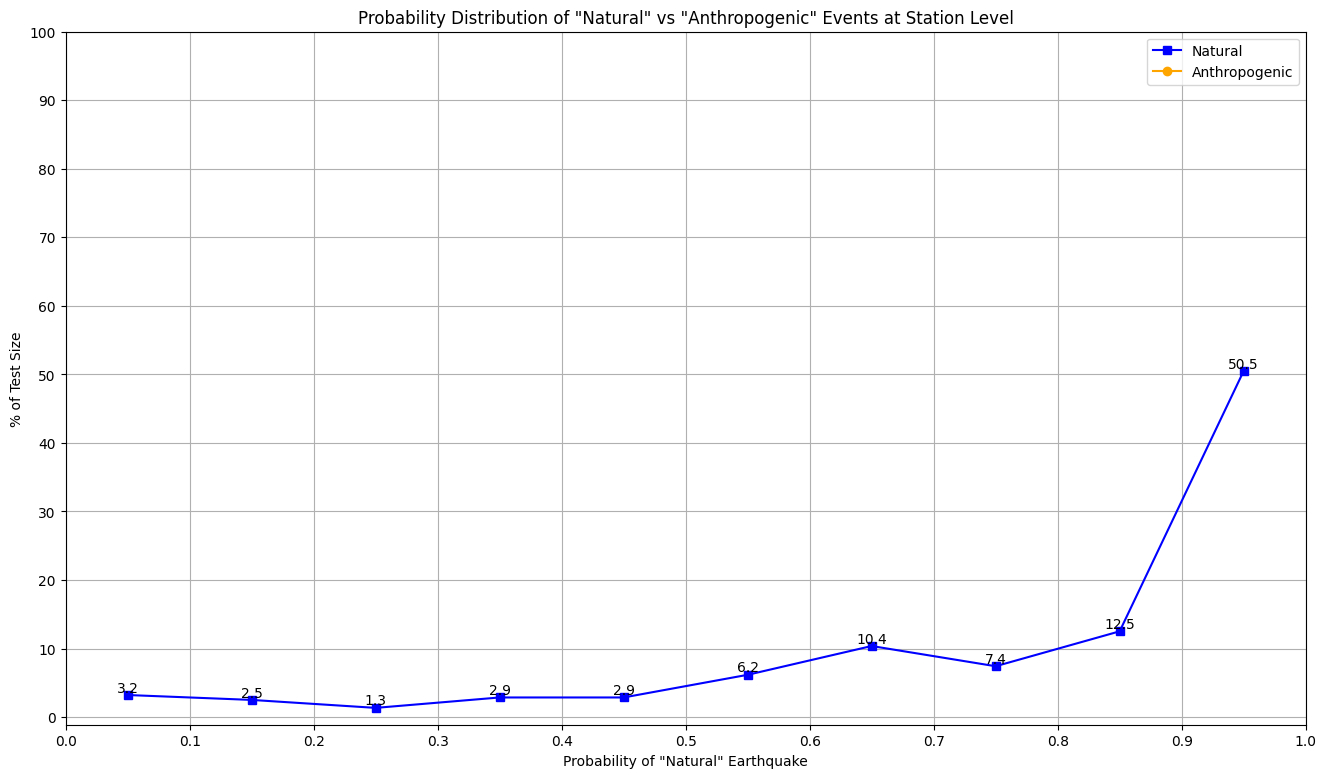

In [13]:
# Suponha que você tenha as seguintes listas de probabilidades para eventos naturais e antropogênicos
prob_anthropogenic = sismo_antrop['prob_nat']
prob_natural = sismo_natural['prob_nat']

# Calcular frequências em porcentagem
freq_natural, bins_natural = np.histogram(prob_natural, bins=np.arange(0, 1.1, 0.1))
freq_anthropogenic, bins_anthropogenic = np.histogram(prob_anthropogenic, bins=np.arange(0, 1.1, 0.1))

# Convert frequency to percentage of the test size
freq_natural = (freq_natural / len(sismo_natural)) *100
freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100

# As posições dos centros dos bins para plotar
bin_centers = (bins_natural[:-1] + bins_natural[1:]) / 2

# Criar o gráfico de linhas
plt.figure(figsize=(16, 9))
plt.plot(bin_centers, freq_natural, marker='s', color='blue', label='Natural')
plt.plot(bin_centers, freq_anthropogenic, marker='o', color='orange', label='Anthropogenic')

# Adicionar anotações com a porcentagem em cima de cada ponto do gráfico
for x, y in zip(bin_centers, freq_natural):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')
for x, y in zip(bin_centers, freq_anthropogenic):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')

# Configurando os ticks do eixo x e y
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 101, 10))

# Adicionar legendas, títulos e rótulos
plt.legend()
plt.title('Probability Distribution of "Natural" vs "Anthropogenic" Events at Station Level')
plt.xlabel('Probability of "Natural" Earthquake')
plt.ylabel('% of Test Size')

# Mostrar o gráfico
plt.grid(True)
plt.show()

In [14]:
pred_net[pred_net['prob_nat'].isna()]

,event,label_cat,prob_nat,prob_ant,pred,nature
798,20210303T033512,0,NaN,NaN,0,Natural
886,20221213T032627,0,NaN,NaN,0,Natural
1027,20210303T034320,0,NaN,NaN,0,Natural


In [15]:
# Suponha que seu DataFrame seja algo como:
df = pred_net
df.dropna(inplace=True)

Acurácia: 0.8718637992831542

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1116
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1116
   macro avg       0.50      0.44      0.47      1116
weighted avg       1.00      0.87      0.93      1116


Matriz de Confusão:
 [[973 143]
 [  0   0]]


/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


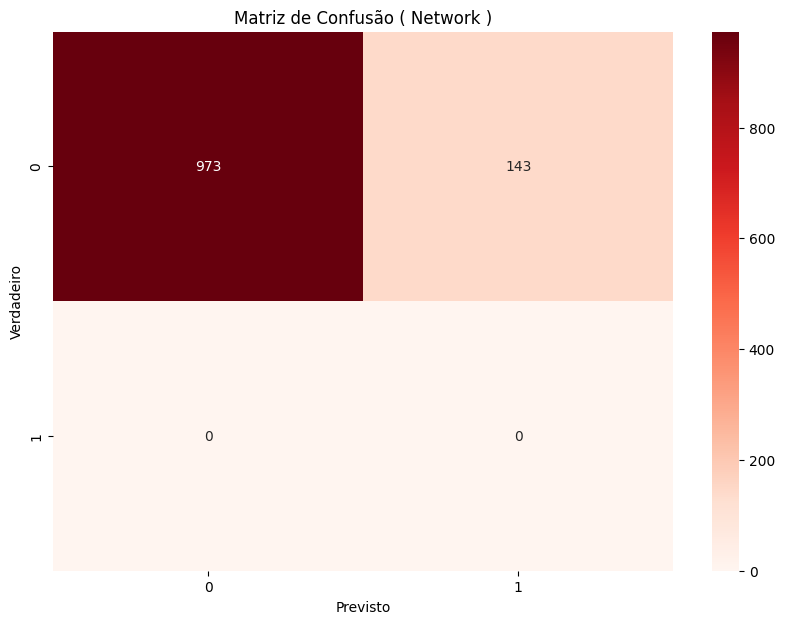

In [16]:
# Extraindo os rótulos verdadeiros e previstos
y_true = df['label_cat']
y_pred = df['pred']

# Calculando a acurácia
accuracy = accuracy_score(y_true, y_pred)
print("Acurácia:", accuracy)

# Gerando o relatório de classificação
report = classification_report(y_true, y_pred)
print("\nRelatório de Classificação:\n", report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusão:\n", conf_matrix)

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Usando Seaborn para criar um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')

# Adicionando títulos e rótulos
plt.title('Matriz de Confusão ( Network )')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')

# Ajustando os rótulos (se necessário)
# plt.xticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
# plt.yticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])

plt.show()

### Extraindo os rótulos verdadeiros e as probabilidades previstas
y_true = df['label_cat']
y_scores = df['prob_ant']

#### Calculando a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

#### Plotando a curva ROC
plt.figure(figsize=(12, 9))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC ( Network )')
plt.legend(loc="lower right")
plt.show()

In [43]:
df

,event,label_cat,prob_nat,prob_ant,pred,nature
0,20200330T033011,0,0.979,0.021,0,Natural
1,20180311T081623,0,0.993,0.007,0,Natural
2,20190109T085554,0,0.984,0.016,0,Natural
3,20151116T053444,0,0.472,0.528,1,Anthropogenic
4,20210512T103742,0,0.938,0.062,0,Natural
...,...,...,...,...,...,...
1114,20201204T070823,0,0.989,0.011,0,Natural
1115,20210201T102302,0,0.998,0.002,0,Natural
1116,20220411T014555,0,0.152,0.848,1,Anthropogenic
1117,20210221T231414,0,0.995,0.005,0,Natural


In [82]:
# Classified as Anthrop
antrop_events = df[df['pred'] == 1]
print(f' # Eventos classificados como antrópicos: {len(antrop_events)}')
# Converter a lista de strings para objetos datetime
antrop_events_datetime = [datetime.strptime(date, "%Y%m%dT%H%M%S") for date in antrop_events.event]
# Extract year, month and hour of each event;
antrop_years, antrop_months, antrop_hours = zip(*[(date.year, date.month, date.hour) for date in antrop_events_datetime])

 # Eventos classificados como antrópicos: 143


In [83]:
# Lista para armazenar as horas de eventos de cada ano e os respectivos rótulos (anos)
antrop_events_by_month = defaultdict(list)
antrop_events_by_year = defaultdict(list)
for date in antrop_events_datetime:
    antrop_events_by_month[date.month].append(date.hour)
    antrop_events_by_year[date.year].append(date.hour)
#
antrop_hours_list = []
antrop_years_labels = []

for year in sorted(antrop_events_by_year.keys()):
    antrop_hours_list.append(antrop_events_by_year[year])
    antrop_years_labels.append(year)

In [84]:
# Classified as Natural
natural_events = df[df['pred'] == 0]
print(f' # Eventos classificados como naturais: {len(natural_events)}')
# Converter a lista de strings para objetos datetime
natural_events_datetime = [datetime.strptime(date, "%Y%m%dT%H%M%S") for date in natural_events.event]
# Extract year, month and hour of each event;
natural_years, natural_months, natural_hours = zip(*[(date.year, date.month, date.hour) for date in natural_events_datetime])

 # Eventos classificados como naturais: 973


In [85]:
# Lista para armazenar as horas de eventos de cada ano e os respectivos rótulos (anos)
natural_events_by_month = defaultdict(list)
natural_events_by_year = defaultdict(list)
for date in natural_events_datetime:
    natural_events_by_month[date.month].append(date.hour)
    natural_events_by_year[date.year].append(date.hour)
#
natural_hours_list = []
natural_years_labels = []
for year in sorted(natural_events_by_year.keys()):
    natural_hours_list.append(natural_events_by_year[year])
    natural_years_labels.append(year)

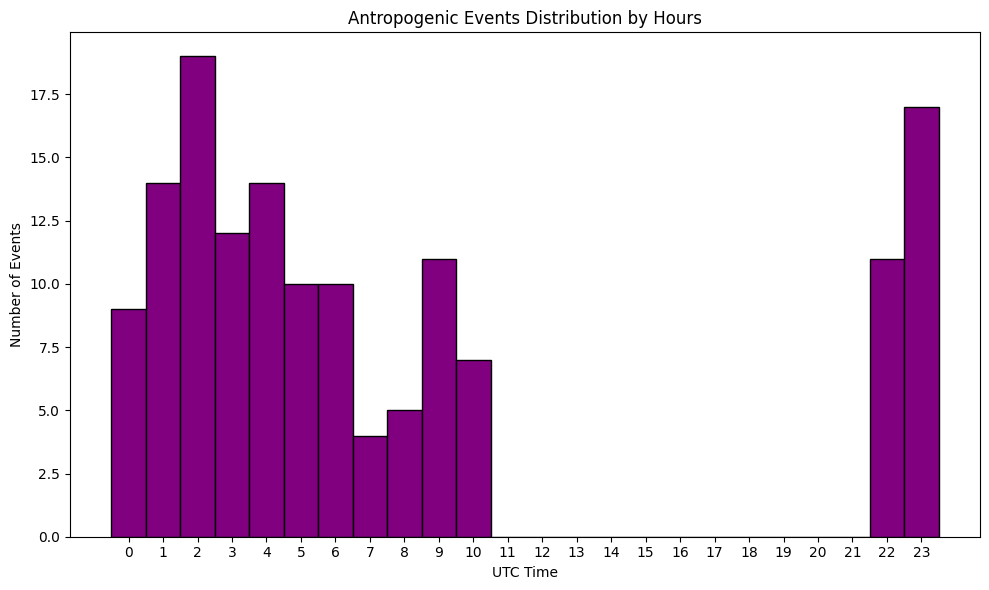

In [89]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(antrop_hours, bins=np.arange(0, 25) - 0.5, color='blue', s , edgecolor='black')
plt.title('Antropogenic Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

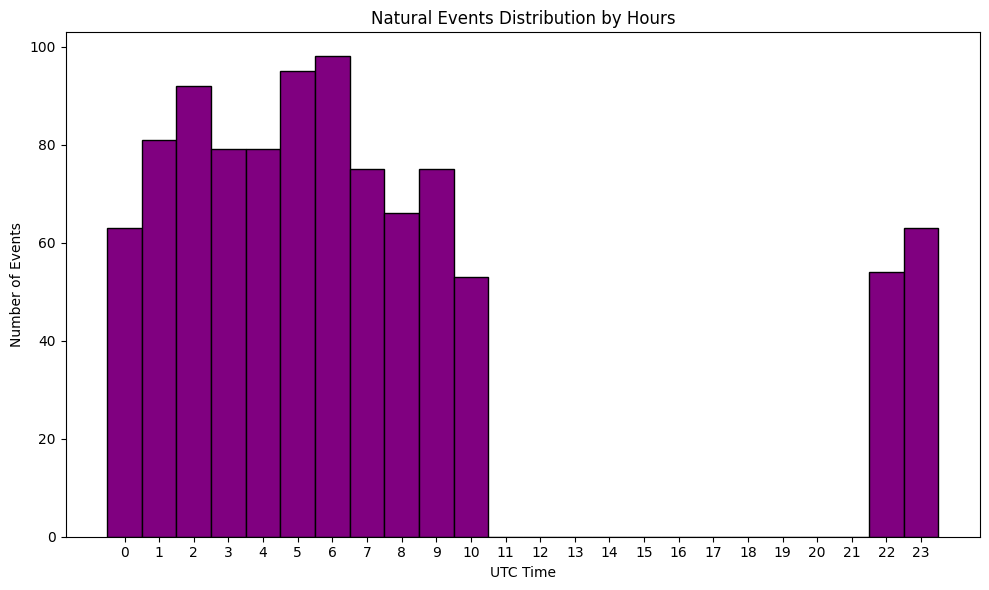

In [88]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(natural_hours, bins=np.arange(0, 25) - 0.5, color='blue', edgecolor='black')
plt.title('Natural Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

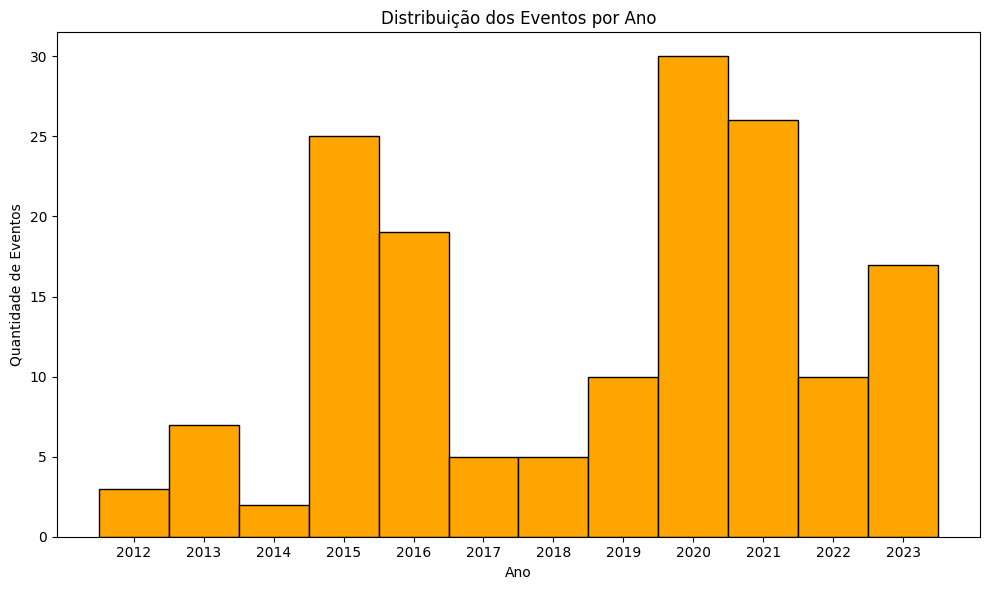

In [207]:
# Plotar o histograma por ano
plt.figure('years',figsize=(10, 6))
plt.hist(antrop_years, bins=np.arange(min(antrop_years), max(antrop_years) + 2) - 0.5, color='orange', edgecolor='black')
plt.title('Distribuição dos Eventos por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(min(natural_years), max(antrop_years) + 1))
plt.tight_layout()
plt.show()

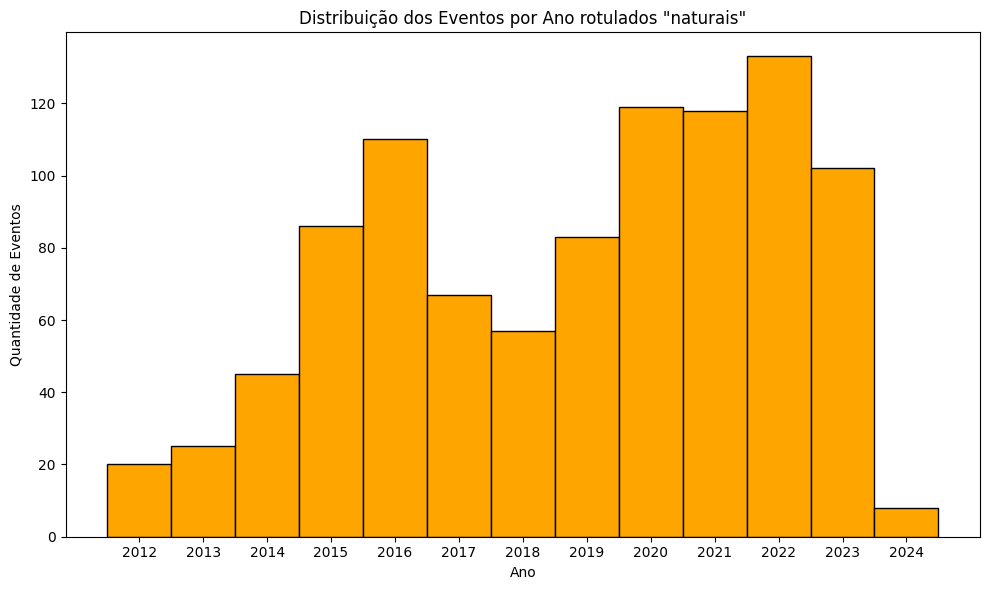

In [95]:
# Plotar o histograma por ano
plt.figure('years',figsize=(10, 6))
plt.hist(natural_years, bins=np.arange(min(natural_years), max(natural_years) + 2) - 0.5, color='orange', edgecolor='black')
plt.title('Distribuição dos Eventos por Ano rotulados "naturais"')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(min(natural_years), max(natural_years) + 1))
plt.tight_layout()
plt.show()

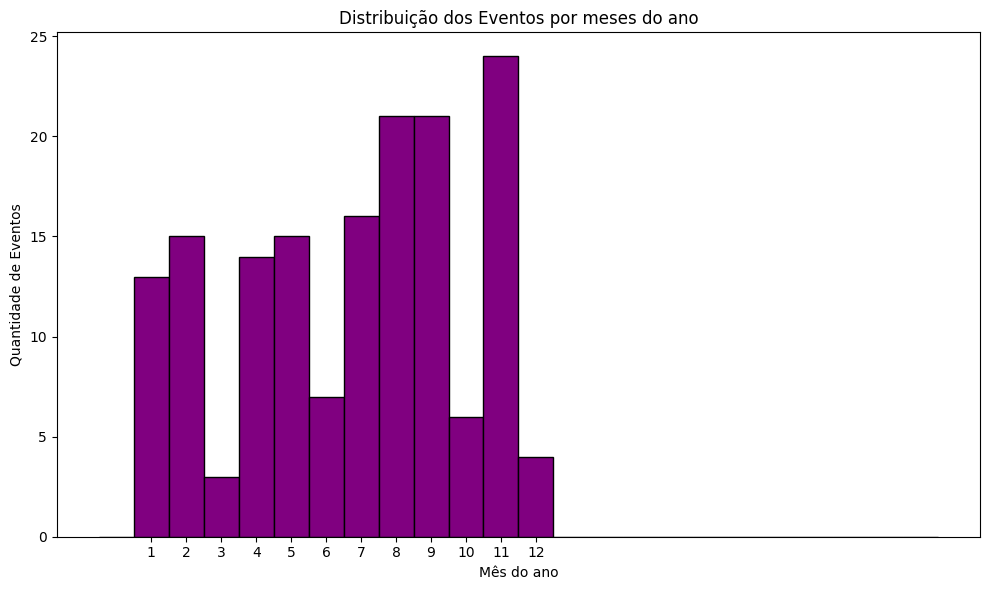

In [208]:
# Plotar o histograma por horas do dia
plt.figure('months',figsize=(10, 6))
plt.hist(antrop_months, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Distribuição dos Eventos por meses do ano')
plt.xlabel('Mês do ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()

### Eventos Classificados como Naturais

In [103]:
natural_events = df[df['pred'] == 0]
print(f' # Eventos classificados como naturais: {len(natural_events)}')

 # Eventos classificados como naturais: 1395


In [104]:
# Converter a lista de strings para objetos datetime
natural_events_datetime = [datetime.strptime(date, "%Y%m%dT%H%M%S") for date in natural_events.event]
# Extrair o ano de cada evento
natural_years = [date.year for date in natural_events_datetime]
# Extrair a hora do dia de cada evento
natural_months = [date.month for date in natural_events_datetime]
# Extrair a hora do dia de cada evento
natural_hours = [date.hour for date in natural_events_datetime]

natural_events_by_month = defaultdict(list)
natural_events_by_year = defaultdict(list)

for date in natural_events_datetime:
    natural_events_by_month[date.month].append(date.hour)
    natural_events_by_year[date.year].append(date.hour)

# Lista para armazenar as horas de eventos de cada ano e os respectivos rótulos (anos)
natural_hours_list = []
natural_years_labels = []

for year in sorted(natural_events_by_year.keys()):
    natural_hours_list.append(natural_events_by_year[year])
    natural_years_labels.append(year)

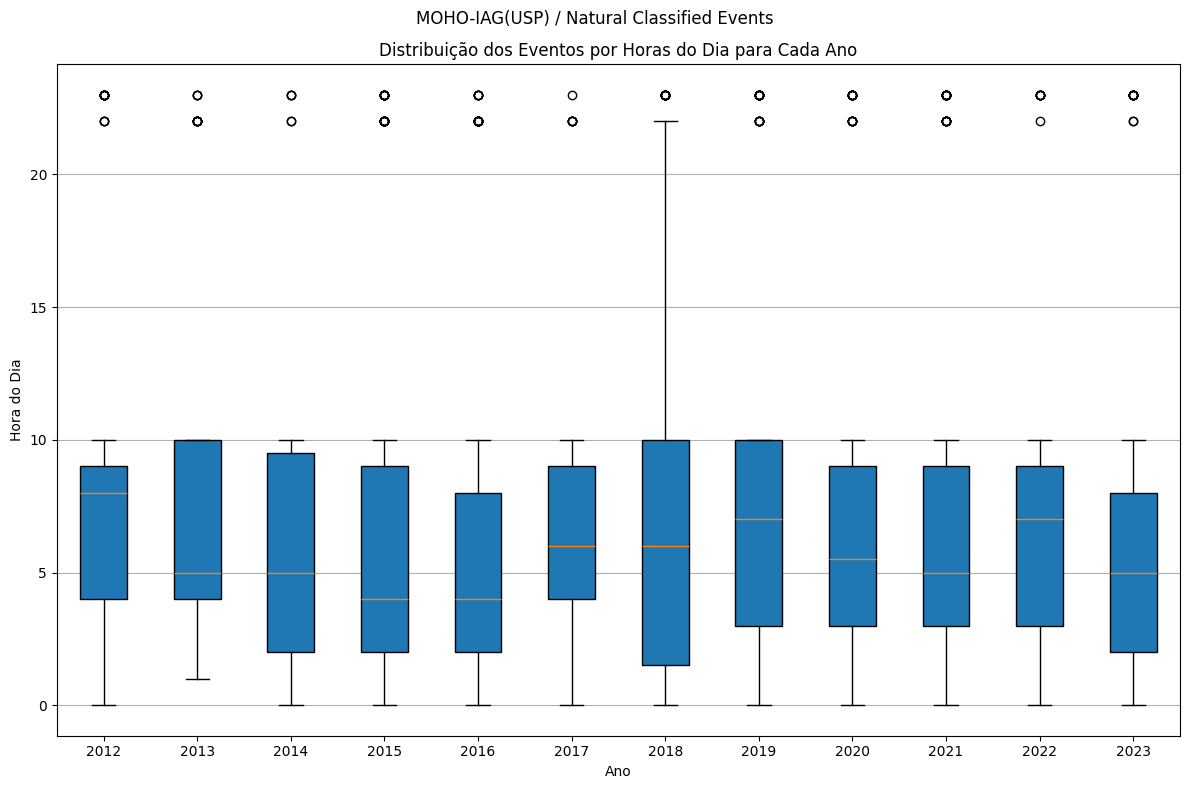

In [105]:
# Plotando os boxplots Hours by Years
plt.figure(figsize=(12, 8))
plt.boxplot(natural_hours_list, patch_artist=True)
plt.suptitle('MOHO-IAG(USP) / Natural Classified Events')
plt.title('Distribuição dos Eventos por Horas do Dia para Cada Ano')
plt.xlabel('Ano')
plt.ylabel('Hora do Dia')
plt.xticks(range(1, len(antrop_years_labels) + 1), antrop_years_labels)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

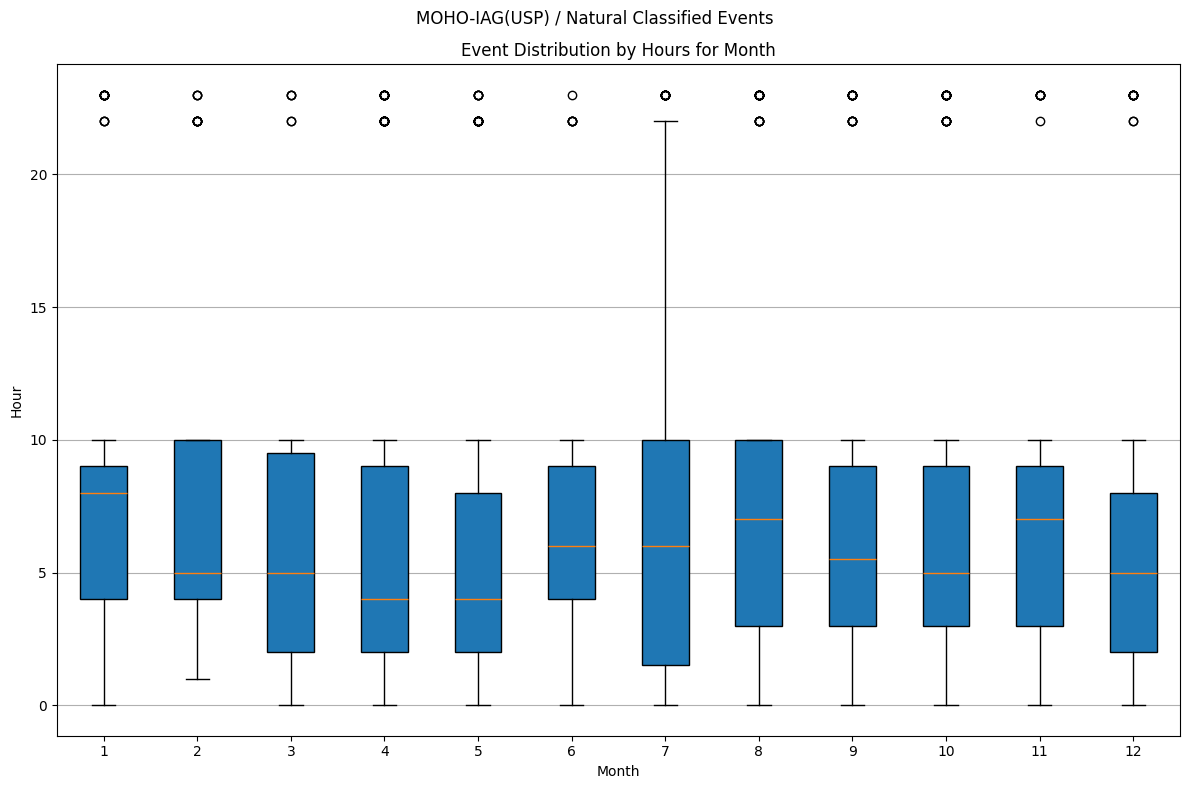

In [106]:
# Plotando os boxplots
plt.figure(figsize=(12, 8))
plt.boxplot(natural_hours_list, patch_artist=True)
plt.suptitle('MOHO-IAG(USP) / Natural Classified Events')
plt.title('Event Distribution by Hours for Month')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.xticks(range(1, len(natural_months_label) + 1), natural_months_label)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

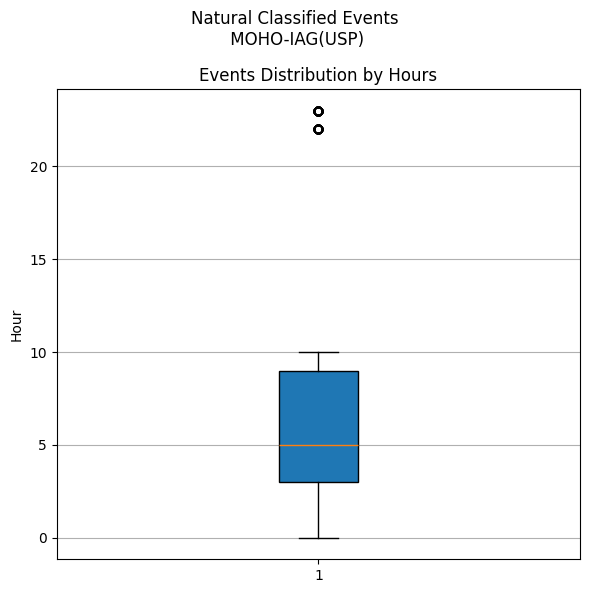

In [107]:
# Plotando os boxplots
plt.figure(figsize=(6, 6))
plt.boxplot(natural_hours, patch_artist=True)
plt.title('Events Distribution by Hours')
plt.suptitle('Natural Classified Events\n MOHO-IAG(USP)')
plt.ylabel('Hour')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

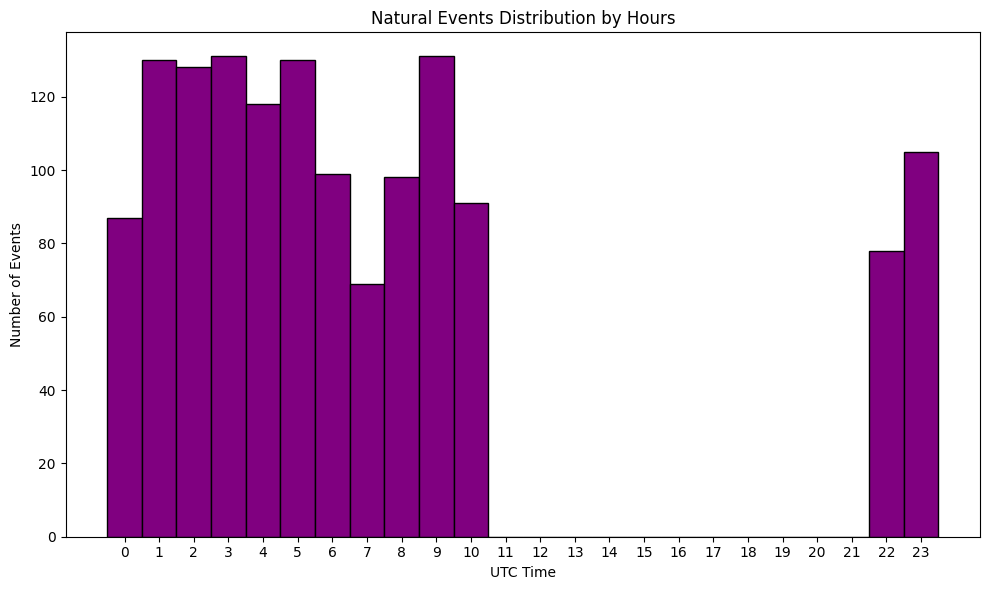

In [108]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(natural_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Natural Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

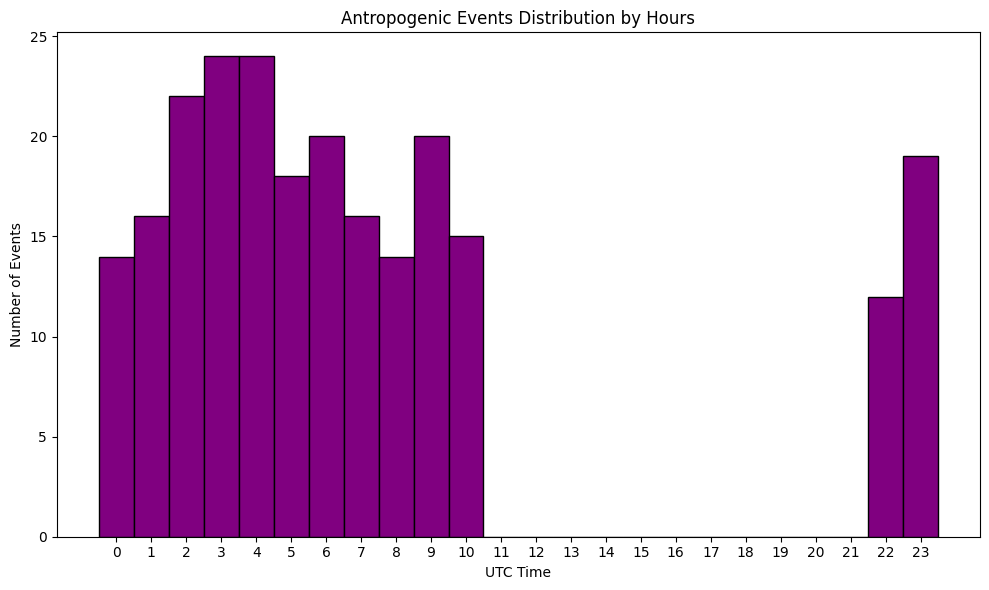

In [109]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(antrop_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Antropogenic Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

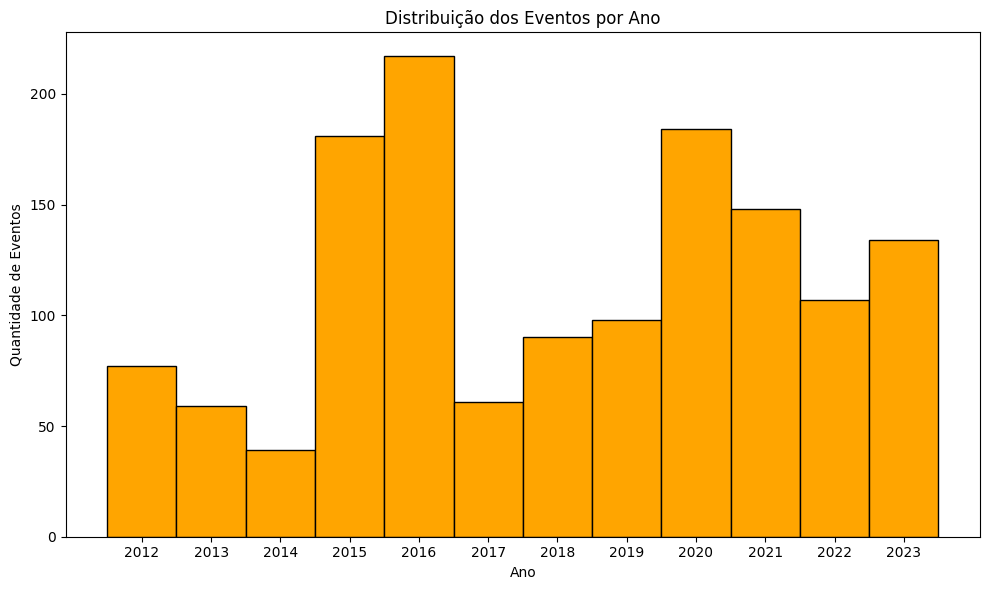

In [112]:
# Plotar o histograma por ano
plt.figure('years',figsize=(10, 6))
plt.hist(natural_years, bins=np.arange(min(natural_years), max(natural_years) + 2) - 0.5, color='orange', edgecolor='black')
plt.title('Distribuição dos Eventos por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(min(natural_years), max(natural_years) + 1))
plt.tight_layout()
plt.show()

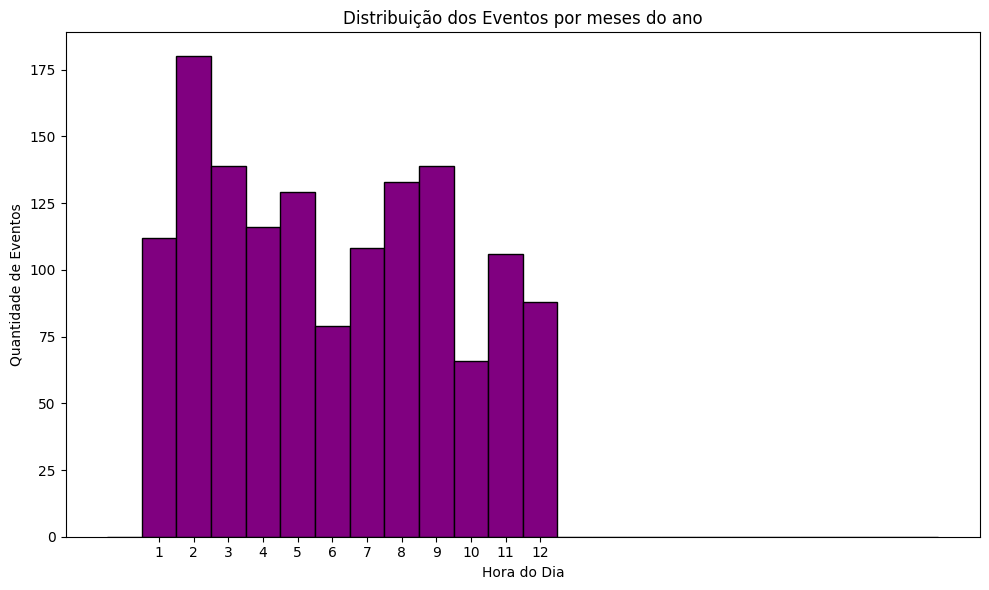

In [113]:
# Plotar o histograma por horas do dia
plt.figure('months',figsize=(10, 6))
plt.hist(natural_months, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Distribuição dos Eventos por meses do ano')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()

## Predições em Estação

In [48]:
pred_sta = pd.read_csv("../files/output/validation_station_level.csv")
pred_sta.head()

,file_name,station,label_cat,prob_nat,prob_ant,pred,nature
0,NB_NBAN_20160323T082644,NBAN,0,0.998,0.002,0,Natural
1,BR_BOAV_20210201T102321,BOAV,0,0.998,0.002,0,Natural
2,BL_MCI6_20130418T101054,MCI6,0,0.918,0.082,0,Natural
3,ON_DUB01_20180725T232908,DUB01,0,0.979,0.021,0,Natural
4,NB_NBPA_20210921T032835,NBPA,0,0.084,0.916,1,Anthropogenic


In [49]:
pred_sta.describe().T

,count,mean,std,min,25%,50%,75%,max
label_cat,1715.0,0.00000,0.000000,0.000,0.00000,0.00,0.00000,0.000
prob_nat,1712.0,0.82668,0.300795,0.001,0.84475,0.98,0.99700,1.000
prob_ant,1712.0,0.17332,0.300795,0.000,0.00300,0.02,0.15525,0.999
pred,1715.0,0.15102,0.358173,0.000,0.00000,0.00,0.00000,1.000


In [50]:
sismo_natural = pred_sta[pred_sta['label_cat'] == 0]
print(f'sismos naturais - > {len(sismo_natural)}')

sismo_antrop = pred_sta[pred_sta['label_cat'] == 1]
print(f'sismos antrópicos - > {len(sismo_antrop)}')

sismos naturais - > 1715
sismos antrópicos - > 0


In [51]:
sismo_falso_natural = sismo_antrop[sismo_antrop['pred'] == 0 ]
print(f'sismos naturais falsos - > {len(sismo_falso_natural)}')

sismo_falso_antro = sismo_natural[sismo_natural['pred'] == 1 ]
print(f'sismos antropogênicos falsos - > {len(sismo_falso_antro)}')

sismos naturais falsos - > 0
sismos antropogênicos falsos - > 259


In [52]:
sismo_verdadeiro_natural = sismo_natural[sismo_natural['pred'] == 0 ]
print(f'sismos naturais verdadeiros - > {len(sismo_verdadeiro_natural)}')

sismo_verdadeiro_antro = sismo_antrop[sismo_antrop['pred'] == 1 ]
print(f'sismos antropogênicos verdadeiros - > {len(sismo_verdadeiro_antro)}')

sismos naturais verdadeiros - > 1456
sismos antropogênicos verdadeiros - > 0


/tmp/ipykernel_1135724/1350128421.py:11: RuntimeWarning: divide by zero encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100
/tmp/ipykernel_1135724/1350128421.py:11: RuntimeWarning: invalid value encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100


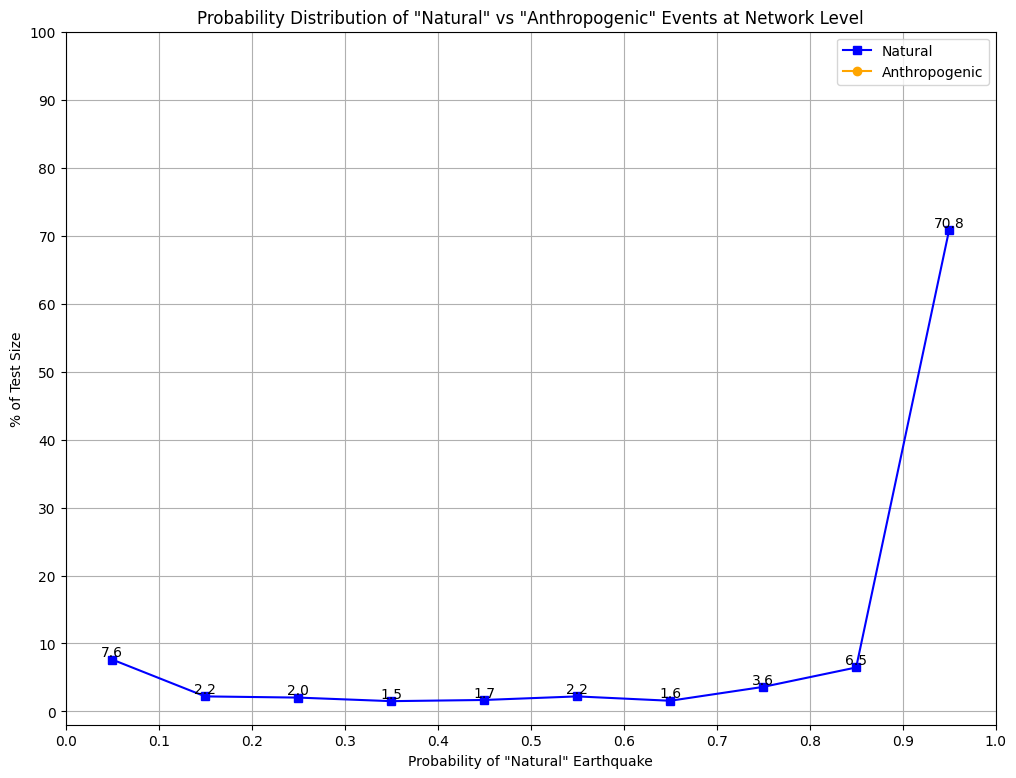

In [53]:
# Suponha que você tenha as seguintes listas de probabilidades para eventos naturais e antropogênicos
prob_anthropogenic = sismo_antrop['prob_nat']
prob_natural = sismo_natural['prob_nat']

# Calcular frequências em porcentagem
freq_natural, bins_natural = np.histogram(prob_natural, bins=np.arange(0, 1.1, 0.1))
freq_anthropogenic, bins_anthropogenic = np.histogram(prob_anthropogenic, bins=np.arange(0, 1.1, 0.1))

# Convert frequency to percentage of the test size
freq_natural = (freq_natural / len(prob_natural)) * 100
freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100

# As posições dos centros dos bins para plotar
bin_centers = (bins_natural[:-1] + bins_natural[1:]) / 2

# Criar o gráfico de linhas
plt.figure(figsize=(12, 9))
plt.plot(bin_centers, freq_natural, marker='s', color='blue', label='Natural')
plt.plot(bin_centers, freq_anthropogenic, marker='o', color='orange', label='Anthropogenic')

# Adicionar anotações com a porcentagem em cima de cada ponto do gráfico
for x, y in zip(bin_centers, freq_natural):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')
for x, y in zip(bin_centers, freq_anthropogenic):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')

# Configurando os ticks do eixo x e y
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 101, 10))

# Adicionar legendas, títulos e rótulos
plt.legend()
plt.title('Probability Distribution of "Natural" vs "Anthropogenic" Events at Network Level')
plt.xlabel('Probability of "Natural" Earthquake')
plt.ylabel('% of Test Size')

# Mostrar o gráfico
plt.grid(True)
plt.show()

/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 0.8489795918367347

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      1715
           1       0.00      0.00      0.00         0

    accuracy                           0.85      1715
   macro avg       0.50      0.42      0.46      1715
weighted avg       1.00      0.85      0.92      1715


Matriz de Confusão:
 [[1456  259]
 [   0    0]]


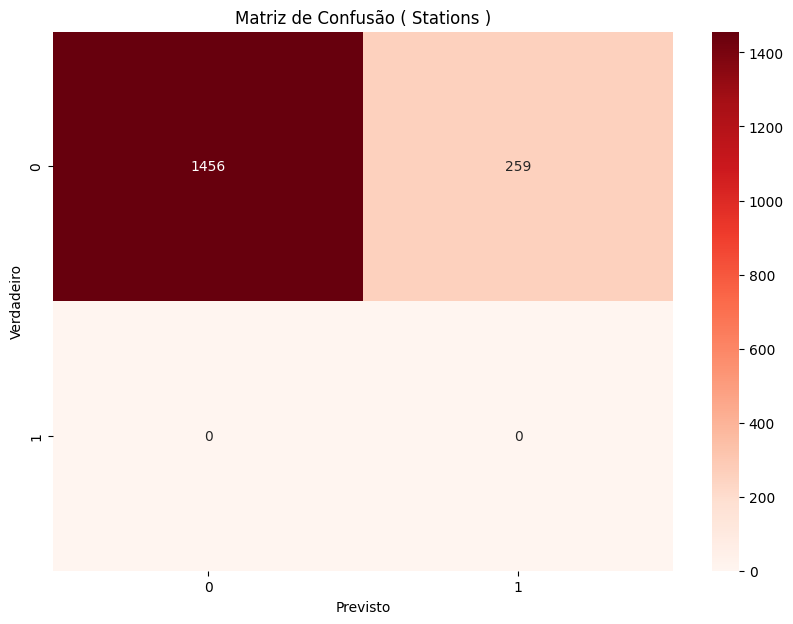

In [54]:
# Suponha que seu DataFrame seja algo como:
df = pred_sta

# Extraindo os rótulos verdadeiros e previstos
y_true = df['label_cat']
y_pred = df['pred']

# Calculando a acurácia
accuracy = accuracy_score(y_true, y_pred)
print("Acurácia:", accuracy)

# Gerando o relatório de classificação
report = classification_report(y_true, y_pred)
print("\nRelatório de Classificação:\n", report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusão:\n", conf_matrix)

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Usando Seaborn para criar um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')

# Adicionando títulos e rótulos
plt.title('Matriz de Confusão ( Stations )')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')

# Ajustando os rótulos (se necessário)
# plt.xticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
# plt.yticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])

plt.show()

In [55]:
df.dropna(inplace=True)
df

,file_name,station,label_cat,prob_nat,prob_ant,pred,nature
0,NB_NBAN_20160323T082644,NBAN,0,0.998,0.002,0,Natural
1,BR_BOAV_20210201T102321,BOAV,0,0.998,0.002,0,Natural
2,BL_MCI6_20130418T101054,MCI6,0,0.918,0.082,0,Natural
3,ON_DUB01_20180725T232908,DUB01,0,0.979,0.021,0,Natural
4,NB_NBPA_20210921T032835,NBPA,0,0.084,0.916,1,Anthropogenic
...,...,...,...,...,...,...,...
1710,NB_NBTA_20200906T035858,NBTA,0,0.952,0.048,0,Natural
1711,BL_PTGB_20151202T014209,PTGB,0,0.226,0.774,1,Anthropogenic
1712,ON_TIJ01_20151202T014209,TIJ01,0,0.979,0.021,0,Natural
1713,NB_NBMO_20220505T084227,NBMO,0,0.998,0.002,0,Natural


In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label_cat,1712.0,0.000000,0.000000,0.000,0.00000,0.00,0.00000,0.000
prob_nat,1712.0,0.826680,0.300795,0.001,0.84475,0.98,0.99700,1.000
prob_ant,1712.0,0.173320,0.300795,0.000,0.00300,0.02,0.15525,0.999
pred,1712.0,0.151285,0.358431,0.000,0.00000,0.00,0.00000,1.000


In [57]:
# Extraindo os rótulos verdadeiros e as probabilidades previstas
y_true = df['label_cat']
y_scores = df['prob_ant']

# Calculando a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plotando a curva ROC
plt.figure(figsize=(12, 9))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC  ( Stations )')
plt.legend(loc="lower right")
plt.show()

/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.